In [1]:
import argparse, sys, os, logging
import numpy as np
import pandas as pd
import powergrid_data
from hmmlearn import hmm
from datetime import datetime
from pandas.tools.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler, normalize
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, WeekdayLocator, DayLocator, HourLocator, AutoDateLocator, DateFormatter, AutoDateFormatter, date2num
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from analysis import analyzer
import warnings


%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
train = 'data/train/train.csv'
test = 'data/test/test_v1.csv'

In [3]:
power_grid = powergrid_data.datasets(train, test)
analyze = analyzer(power_grid)

In [4]:
dates_columns = 'DateTime'
features_columns = ['Global_active_power']

analyze.time_series(dates_columns, features_columns)

In [5]:
## If you modify year, month and day, make sure the above dates_columns is either Date or DateTime

## Both test and train has data of year 2006, 2007 and 2008
Year = 2007

## Months takes a string of month full name e.g 'March'
Month = 'October'
Day = 1

## If you modify hour, minutes and seconds, make sure the above dates_columns is either DateTime or Time
## Hour uses 24 hr clock
Hour = None
Minutes = None
Seconds = None

train_dates, train_features, test_dates, test_features = analyze.parser(year = Year, month = Month, day = Day, hour = Hour, minutes = Minutes, seconds = Seconds)

In [6]:
# Specify Threshold/Tolerance
threshold = 1

# Make an HMM instance and execute fit
model = hmm.GaussianHMM(n_components=4, covariance_type="full", n_iter=200,tol=threshold).fit(train_features)

train_state_seq = model.predict(model.sample(test_features.size)[0])
test_state_seq = model.predict(test_features)

# states assigned by model to data
train_states = model.decode(test_features, algorithm='viterbi')[1]
test_states = model.decode(test_features, algorithm='viterbi')[1]

# find threshold difference
difference = abs(test_features - model.means_[test_states])

# If difference of test_feature data against mean of associated state (as assigned) less than threshold...not anomaly
NotAnomolyBinary = (difference <= threshold)
AnomolyBinary = NotAnomolyBinary == False # if not, it is in fact an anomaly

test_features_anomaly = np.copy(test_features)
test_features_anomaly[NotAnomolyBinary] = None

# keep track/record of anomalies and normal occurrences
#print(difference <= threshold).bool()

# TEST AND DEBUG PURPOSES!
print("Train States + Seq:")
print(train_states)
print(train_state_seq)

print("Test States + Seq:")
print(test_states)
print(test_state_seq)

print("Diff:")
print(difference)

print("Raw Train: ")
print(train_features)
print("Raw Test: ")
print(test_features)

print("Mean for State assigned to Test Data: ")
print(model.means_[test_states])
print("Difference")
print(threshold >= difference)

print("Anomalies (Data = Anom; NaN = Norm):")
print(test_features_anomaly)


Train States + Seq:
[1 3 3 ..., 1 1 1]
[1 1 1 ..., 0 0 0]
Test States + Seq:
[1 3 3 ..., 1 1 1]
[1 3 3 ..., 1 1 1]
Diff:
      Global_active_power
0                1.219902
1                0.845950
2                0.413586
3                0.422945
4                0.416945
5                0.706705
6                0.412945
7                0.736805
8                0.418945
9                0.766355
10               0.420945
11               0.815155
12               0.851405
13               0.364945
14               0.935705
15               0.352945
16               0.352945
17               0.348945
18               0.394500
19               0.366041
20               0.321500
21               0.287350
22               1.739750
23               1.737750
24               0.279750
25               0.180500
26               0.456250
27               2.925308
28               0.894250
29               0.484050
...                   ...
1410             0.166247
1411             0.95

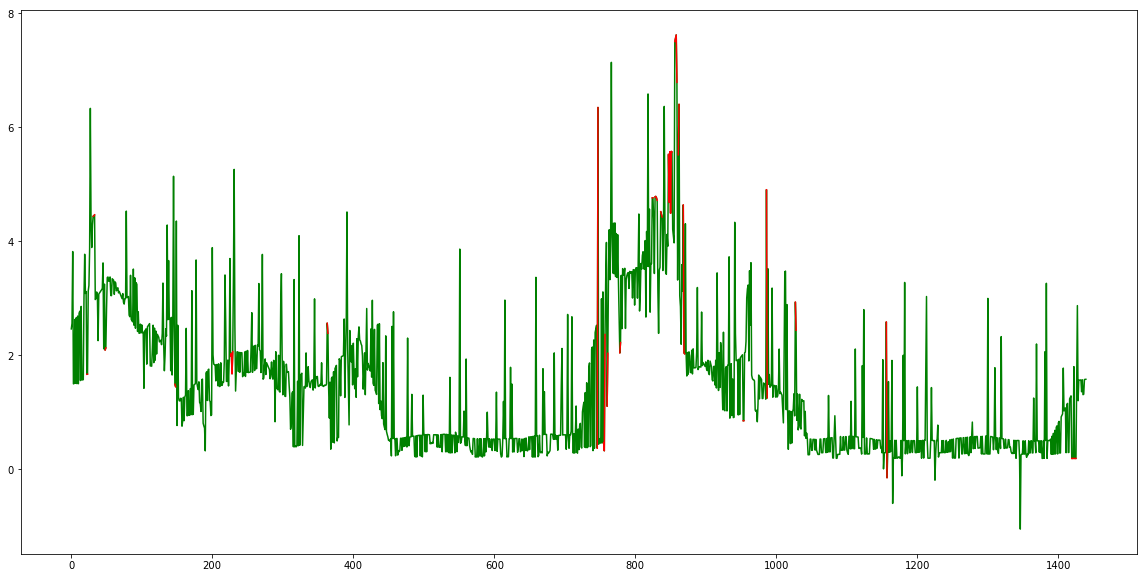

In [7]:
plt.figure(figsize=(20,10))

# green is the original test data
plt.plot(test_features, color='g')

# blue is the train data
# plt.plot(train_state_seq, color='b')

# red is the test data anomaly
plt.plot(test_features_anomaly, color='r')